In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery
import numpy as np
from matplotlib.patches import Rectangle
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import sys
import os
import shutil
import pickle
import healpy as hp
import h5py
import pandas as pd

###clevar
import clevar
from clevar import ClCatalog
from clevar.match import ProximityMatch
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances


In [26]:
#print(cat.list_all_quantities())
#print(amico_data.colnames)

In [27]:
cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_small")
cosmodc2_data = cat.get_quantities(['halo_id', 'ra', 'dec', 'redshift'], filters=['halo_mass > 1e14', 'is_central'])

inpath = '/sps/lsst/users/tguillem/DESC/desc_april_2022/cluster_challenge/clevar_catalogs/amico/map_detections_refined_noBuffer_all.fits'
amico_data = Table.read(inpath)['ID', 'Xphys', 'Yphys', 'Zphys',]

In [28]:
display(cosmodc2_data)
display(amico_data)

{'dec': array([-40.51640122, -40.85932206, -39.59505755, ..., -41.44924737,
        -42.37257032, -37.37798131]),
 'ra': array([62.55277181, 62.6239115 , 61.75471519, ..., 69.75498205,
        68.07754574, 64.78081571]),
 'redshift': array([0.24844585, 0.24752604, 0.37716924, ..., 2.30642828, 2.23963483,
        2.3170319 ]),
 'halo_id': array([ 131800155392,  230000155392,  268600155355, ..., 4689500170144,
        1332400181151, 3820800128148])}

ID,Xphys,Yphys,Zphys
int16,float64,float64,float64
3,61.378983,-39.994438,0.78999996
7,61.758209,-39.59544,0.35999998
9,62.62199,-40.858124,0.25
10,62.198517,-39.405045,0.54999995
11,61.961666,-41.425468,0.63
12,62.013664,-40.785416,0.74999994
13,61.476517,-41.169827,0.36999997
14,61.914318,-40.275494,0.63
15,62.070724,-39.970333,0.48999998


In [29]:
cdc = ClCatalog('Cat_cosmoDC2', id=cosmodc2_data['halo_id'], ra=cosmodc2_data['ra'], dec=cosmodc2_data['dec'], z=cosmodc2_data['redshift'])
cam = ClCatalog('Cat_amico', id=amico_data['ID'], ra=amico_data['Xphys'], dec=amico_data['Yphys'], z=amico_data['Zphys'])

/sps/lsst/users/namourou/conda_clone_210223/descv1.1/clevar/clevar/catalog.py:501: UserWarning: Repeated ID's in id column, adding suffix _r# to them.
  warnings.warn(


In [ ]:
"""
# Format for nice display
for c in ('ra', 'dec', 'z'):
    cdc[c].info.format = '.2f'
    cam[c].info.format = '.2f'
display(cdc)
display(cam)
"""

In [6]:
from clevar.match import ProximityMatch
mt = ProximityMatch()

In [7]:
match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'angular_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':.2,
                'match_radius': '1 mpc'
                },
    'catalog2': {'delta_z':.2,
                'match_radius': '10 arcsec'
                }
}
match_config2 = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'redshift_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':.2,
                'match_radius': '1 mpc'
                },
    'catalog2': {'delta_z':.2,
                'match_radius': '10 arcsec'
                }
}
from clevar.cosmology import AstroPyCosmology
cosmo = AstroPyCosmology()

In [9]:
mt.match_from_config(c1, c2, match_config, cosmo=cosmo)


## ClCatalog 1
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (Cat1)
* 4/5 objects matched.

## Multiple match (catalog 2)
Finding candidates (Cat2)
* 4/4 objects matched.

## Finding unique matches of catalog 1
Unique Matches (Cat1)
* 4/5 objects matched.

## Finding unique matches of catalog 2
Unique Matches (Cat2)
* 4/4 objects matched.
Cross Matches (Cat1)
* 4/5 objects matched.
Cross Matches (Cat2)
* 4/4 objects matched.


In [10]:
display(c1)
display(c2)

In [11]:
from clevar.match import get_matched_pairs
mt1, mt2 = get_matched_pairs(c1, c2, 'cross')

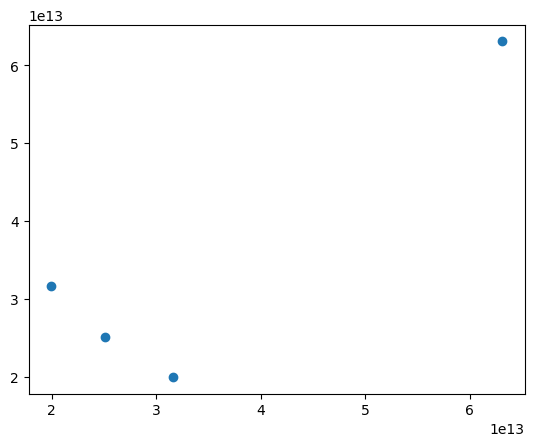

In [12]:
import pylab as plt
plt.scatter(mt1['mass'], mt2['mass'])